## Modeling with Ensemble Method: Random Forest

In this notebook I will try out a few iterations of **Random Forest algorithm** and see which parameters and features maximize our **Class 2 recall score**

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
#import
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, recall_score, make_scorer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
#import customized functions
from src.data_cleaning import cleaning_functions as cfs
from src.data_cleaning import exploration_functions as efs
from src.data_cleaning import processing_functions as pfs
from src.data_cleaning import modeling_functions as mfs

In [2]:
X_train, X_test, y_train, y_test, classes_dict = pfs.processed_dataset()
X_train, X_test = pfs.ohe_train_and_test_features(X_train, X_test)
scorer = mfs.scorer()

In [3]:
X_train_smoted, y_train_smoted = SMOTE(random_state=2020).fit_sample(X_train.values, y_train)

### Random Forest Algorithm

>adding an extra layer of randomization: Instead of using *all* the features of dataset to optimize a branch at each node, we'll just choose a subset of our features.

In [5]:
# Instantiating a RandomForestClassifier
rf1 = RandomForestClassifier(random_state=2020, class_weight='balanced')
rf1.fit(X_train, y_train)
print('Class 2 recall score :','\n',cross_val_score(rf1, X_train, y_train, scoring=scorer, cv=3))

Class 2 recall score : 
 [0.75945378 0.76908263 0.76768207]


Not a bad start, averaging around 76% recall score for class 2

Let's check out the smoted lot and see if they look any good

In [6]:
rf2 = RandomForestClassifier(random_state=2020)
rf2.fit(X_train_smoted, y_train_smoted)
print('Class 2 recall score :','\n',cross_val_score(rf2, X_train_smoted, y_train_smoted, scoring=scorer, cv=3))

Class 2 recall score : 
 [0.77458864 0.76196957 0.60942719]


High variance in this bunch, not as promising as the earlier one...

Let's try out **grid search**

In [7]:
# Defining param grid.
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2', 1],
    'criterion': ["gini", "entropy"],
    
}

# Initializing gridsearch with 3-fold cross-validation.
gs = GridSearchCV(estimator=rf1, param_grid=param_grid, cv=3, scoring=scorer)

In [8]:
gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=2020),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2', 1],
                         'n_estimators': [50, 100, 150]},
             scoring=make_scorer(class_2_recall))

**It took its time but we have something!!!!!**

In [9]:
gs.best_params_

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 150}

In [10]:
gs.best_estimator_

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2', n_estimators=150,
                       random_state=2020)

Let's try it out!!!!

In [11]:
rf3 = RandomForestClassifier(class_weight='balanced', criterion='entropy', 
                             max_features='log2', n_estimators=150,
                             random_state=2020)
rf3.fit(X_train, y_train)
print('Class 2 recall score :','\n',cross_val_score(rf3, X_train, y_train, scoring=scorer, cv=3))

Class 2 recall score : 
 [0.7657563  0.76523109 0.77153361]


That's pretty good! low variance between these folds but bias is still on the higher side but its our best performer since we began ensemble methods! 

#### I'm just too curiuos and can't wait to try this out on our test data, I'm going for it!

In [12]:
recall_score(y_test, rf3.predict(X_test), average=None)[2]

0.7670534458509142

That's pretty decent, close to what we had for the training set

In [20]:
print(classification_report(y_test, rf3.predict(X_test),
                            target_names=['Functional',
                                          'Functional, Needs Repair',
                                          'Nonfunctional']))

                          precision    recall  f1-score   support

              Functional       0.79      0.89      0.84      8010
Functional, Needs Repair       0.58      0.31      0.41      1152
           Nonfunctional       0.83      0.77      0.80      5688

                accuracy                           0.80     14850
               macro avg       0.73      0.66      0.68     14850
            weighted avg       0.79      0.80      0.79     14850



No too bad, also our overall accuracy is at 80% which is not entirely bad.

Also curious to see how these parameters behave with the smoted data

In [16]:
rf4 = RandomForestClassifier(random_state=2020,criterion='entropy', 
                             max_features='log2', n_estimators=150)
rf4.fit(X_train_smoted, y_train_smoted)
print('Class 2 recall score :','\n',cross_val_score(rf4, X_train_smoted, y_train_smoted, scoring=scorer, cv=3))

Class 2 recall score : 
 [0.77446493 0.76407275 0.62984041]


higher variance with smoted data, could be just random chance....

**Grid search** was limited to the chosen param-grid. Let's try out a few more iterations

In [22]:
rf5 = RandomForestClassifier(class_weight='balanced', criterion='entropy', 
                             max_features='log2', n_estimators=450,
                             min_samples_split=5, min_samples_leaf=3,
                             random_state=2020)
rf5.fit(X_train, y_train)
print('Class 2 recall score :','\n',cross_val_score(rf5, X_train, y_train, scoring=scorer, cv=3))

Class 2 recall score : 
 [0.72776611 0.72776611 0.74019608]


Not impressive, let's keep going...

#### Going back to the best so far and tweaking it by increasing the `n_estimators` alone to 600!

In [24]:
rf6 = RandomForestClassifier(class_weight='balanced', criterion='entropy', 
                             max_features='log2', n_estimators=600,
                             random_state=2020)
rf6.fit(X_train, y_train)
print('Class 2 recall score :','\n',cross_val_score(rf6, X_train, y_train, scoring=scorer, cv=3))

Class 2 recall score : 
 [0.76645658 0.76698179 0.77118347]


The runtime on this one wa very long but the results were similar to its earlier version `rf3`, not worth trying on the smoted data, 

Let's try another iteration before settling for our best model so far

In [28]:
rf7 = RandomForestClassifier(class_weight='balanced', criterion='entropy', 
                             max_features='log2', n_estimators=200,
                             random_state=2020)
rf7.fit(X_train, y_train)
print('Class 2 recall score :','\n',cross_val_score(rf7, X_train, y_train, scoring=scorer, cv=3))

Class 2 recall score : 
 [0.76628151 0.76663165 0.7710084 ]


Only a slight overall increase when compared to our `rf3` model. Let's go with this new one and test on our testing set and print out a report for final comparison

In [91]:
sorted(list(zip(X_train.columns, rf7.feature_importances_)), key=lambda x: x[1], reverse=True)[:20]

[('longitude', 0.14760880319320208),
 ('latitude', 0.14454789280256236),
 ('population', 0.07143115844398291),
 ('construction_year', 0.05409489090510416),
 ('dry', 0.03911514193181044),
 ('enough', 0.022364423749381544),
 ('insufficient', 0.015017471613087002),
 ('other', 0.014927762952718148),
 ('other', 0.013775772574932022),
 ('never pay', 0.013721293969689423),
 ('gravity', 0.011379367755001613),
 ('communal standpipe', 0.011090102838493727),
 ('above surface up to 1250', 0.009398245412234656),
 ('pay monthly', 0.008880822969308212),
 ('above surface upto 1750', 0.008758911289176927),
 ('True', 0.008078525606993332),
 ('hand pump', 0.008029875051156661),
 ('soft', 0.007737218709698372),
 ('spring', 0.007615047462805865),
 ('VWC', 0.007578655764626777)]

In [35]:
recall_score(y_test, rf7.predict(X_test), average=None)[2]

0.7663502109704642

In [92]:
print(classification_report(y_test, rf7.predict(X_test),
                            target_names=['Functional',
                                          'Functional, Needs Repair',
                                          'Nonfunctional']))

                          precision    recall  f1-score   support

              Functional       0.79      0.89      0.84      8010
Functional, Needs Repair       0.58      0.31      0.41      1152
           Nonfunctional       0.83      0.77      0.80      5688

                accuracy                           0.80     14850
               macro avg       0.73      0.65      0.68     14850
            weighted avg       0.79      0.80      0.79     14850



In [103]:
%matplotlib inline

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


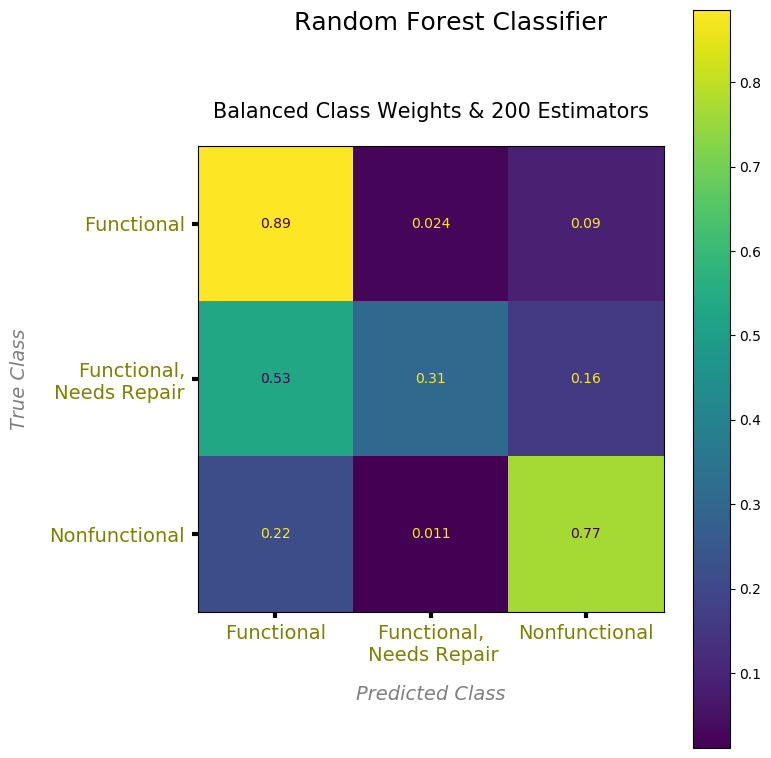

In [117]:

f,ax = plt.subplots(figsize=((8,8)))
plot_confusion_matrix(rf7, X_test, y_test, normalize='true',
                      display_labels=['Functional',
                                      'Functional,\n Needs Repair',
                                      'Nonfunctional'], ax=ax)

ax.set_title('Balanced Class Weights & 200 Estimators', fontsize=15, pad=20)
ax.tick_params(labelsize=14, labelcolor='olive' ,width=3, pad=5, length=4)
ax.set_xlabel('Predicted Class', fontsize=14, labelpad=14, fontstyle='italic', color='grey')
ax.set_ylabel('True Class', fontsize=14, labelpad=14, fontstyle='italic', color='grey')
f.suptitle("               Random Forest Classifier ", fontsize=18)

f.tight_layout()
f.show()
plt.savefig('bestmodelplot.png');

In [93]:
rf8 = RandomForestClassifier(class_weight='balanced', criterion='gini', 
                             max_features='log2', n_estimators=200,
                             random_state=2020)
rf8.fit(X_train, y_train)
print('Class 2 recall score :','\n',cross_val_score(rf8, X_train, y_train, scoring=scorer, cv=3))

Class 2 recall score : 
 [0.76435574 0.7657563  0.77153361]


In [95]:
sorted(list(zip(X_train.columns, rf8.feature_importances_)), key=lambda x: x[1], reverse=True)[:20]

[('longitude', 0.14919309341696407),
 ('latitude', 0.1450575900321472),
 ('population', 0.07152130429283068),
 ('construction_year', 0.0541256380957634),
 ('dry', 0.04255861601998098),
 ('enough', 0.022503200432699412),
 ('other', 0.01579547238159948),
 ('insufficient', 0.015046248399207728),
 ('other', 0.014925883103681386),
 ('never pay', 0.013559517374132352),
 ('gravity', 0.011191418289113826),
 ('communal standpipe', 0.010767203149911175),
 ('above surface up to 1250', 0.009096383078751918),
 ('pay monthly', 0.00844105619373425),
 ('above surface upto 1750', 0.008222018705539687),
 ('pay per bucket', 0.007862955116736235),
 ('spring', 0.007837155453292445),
 ('True', 0.007789355124156085),
 ('hand pump', 0.007774677205365361),
 ('soft', 0.007566519466244559)]

In [96]:
recall_score(y_test, rf8.predict(X_test), average=None)[2]

0.7689873417721519